In [239]:
import warnings
warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings("ignore")

import os
import logging
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
sns.set()
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet
# custom functions
import sys
sys.path.append("/Users/user/Pharmaceutical_Sales_prediction")
from scripts import util
from scripts import plot

In [240]:
### Logger
log = logging.getLogger()
log.info('check')

INFO:root:check


In [241]:
## Read Datas

store_file = '../data/store.csv'
test_file = '../data/test.csv'
train_file = '../data/train.csv'

In [242]:
store_df = pd.read_csv(store_file, low_memory = False)

In [243]:
train_df = pd.read_csv(train_file, parse_dates = True, low_memory = False)

In [244]:
test_df = pd.read_csv(test_file, parse_dates = True, low_memory = False)

## Exploratory Data Analysis 

In this first section we go through the train and store data, handle missing values and create new features for further analysis.

### Info About Datasets

In [245]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [246]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [247]:
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             41088 non-null  int64         
 1   Store          41088 non-null  int64         
 2   DayOfWeek      41088 non-null  int64         
 3   Date           41088 non-null  datetime64[ns]
 4   Open           41077 non-null  float64       
 5   Promo          41088 non-null  int64         
 6   StateHoliday   41088 non-null  object        
 7   SchoolHoliday  41088 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


In [248]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [249]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [250]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [251]:
# data extraction
# !!!!! HOW !!!!!
# train_df['Date'] = pd.to_datetime(train_df['Date'])
# train_df['Year'] = train_df['Date'].dt.year
# train_df['Month'] = train_df.index.month
# train_df['Day'] = train_df.index.day
# train_df['WeekOfYear'] = train_df.index.weekofyear
# len(train_df.index.week)
# train_df.index.week

'''
https://stackoverflow.com/questions/55776571/how-to-split-a-date-column-into-separate-day-month-year-column-in-pandas
'''


'\nhttps://stackoverflow.com/questions/55776571/how-to-split-a-date-column-into-separate-day-month-year-column-in-pandas\n'

In [252]:
# time series as indexes
train_df.index

RangeIndex(start=0, stop=1017209, step=1)

In [253]:
# preparation: input should be float type
# data extraction
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['Day'] = train_df['Date'].dt.day
train_df['WeekOfYear'] = train_df['Date'].dt.weekofyear
len(train_df['Date'].dt.week)
train_df['Date'].dt.week

# adding new variable
train_df['SalePerCustomer'] = train_df['Sales']/train_df['Customers']
train_df['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

### ECDF: empirical cumulative distribution function

To get the first impression about continious variables in the data we can plot ECDF.

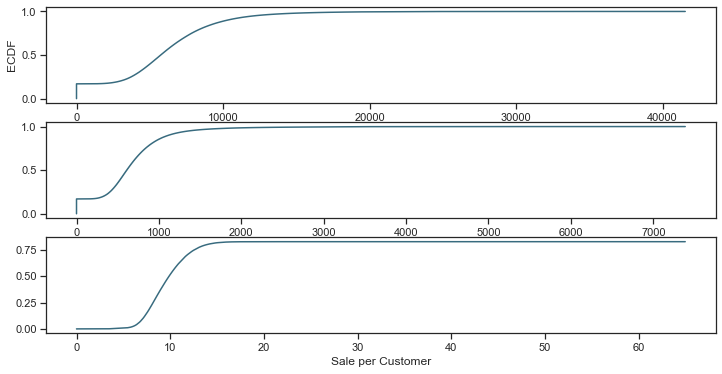

In [254]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train_df['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train_df['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train_df['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

About 20% of data has zero amount of sales / customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000. So what about zero sales, is it only due to the fact that the store is closed?

### Null Percentages

In [255]:
print(f"Store Null Percentage : {util.get_null_percentage(store_df)} %")
print(f"Train Null Percentage : {util.get_null_percentage(train_df)} %")
print(f"Test Null Percentage : {util.get_null_percentage(test_df)} %")

INFO:root:util.py - calculate null percentage: 21.01
INFO:root:util.py - calculate null percentage: 1.21


Store Null Percentage : 21.01 %


INFO:root:util.py - calculate null percentage: 0.0


Train Null Percentage : 1.21 %
Test Null Percentage : 0.0 %


#### View Null Columns count

In [256]:
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [257]:
# No particular pattern observed. In this case, it makes a complete sense to replace NaN with the median values
store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median(), inplace = True)

In [258]:
store_df.fillna(0, inplace = True)
store_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [259]:
### Closed stores with no sales will not be counted for forcaset
# train_df = train_df[(train_df.Open != 0) & (train_df.Sales != 0)]
train_df = util.add_month_year(train_df)
train_df.head()


INFO:root:util.py - Year, Month, Day, WeekOfYear for Dataframe


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [260]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
print("In total: ", train_store.shape)
train_store = pd.merge(train_df, store_df, how='inner', on='Store')
train_store['StateHoliday'] = train_store['StateHoliday'].apply(lambda x: str(x))
train_store

Joining train set with an additional store information.
In total:  (1017209, 25)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,2013,...,14.073746,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,2013,...,13.926380,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,2013,...,14.323333,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,2013,...,12.121311,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [261]:
print(f"Null Percentage of Train and Score : {util.get_null_percentage(train_store)} %")
# train_store.to_csv('../data/clean_train_store.csv', index=False)

INFO:root:util.py - calculate null percentage: 0.74


Null Percentage of Train and Score : 0.74 %


In [262]:
test_df = util.add_month_year(test_df)
test_df.head()

INFO:root:util.py - Year, Month, Day, WeekOfYear for Dataframe


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,17,38
1,2,3,4,2015-09-17,1.0,1,0,0,2015,9,17,38
2,3,7,4,2015-09-17,1.0,1,0,0,2015,9,17,38
3,4,8,4,2015-09-17,1.0,1,0,0,2015,9,17,38
4,5,9,4,2015-09-17,1.0,1,0,0,2015,9,17,38


### Store types
In this section we will closely look at different levels of StoreType and how the main metric Sales is distributed among them.

In [263]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


StoreType B has the highest average of Sales among all others, however we have much less data for it. So let's print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one:

In [264]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541434,3165334859
b,31465621,159231395
c,92129705,783221426
d,156904995,1765392943


Clearly stores of type A. StoreType D goes on the second place in both Sales and Customers. What about date periods? Seaborn's facet grid is the best tool for this task:

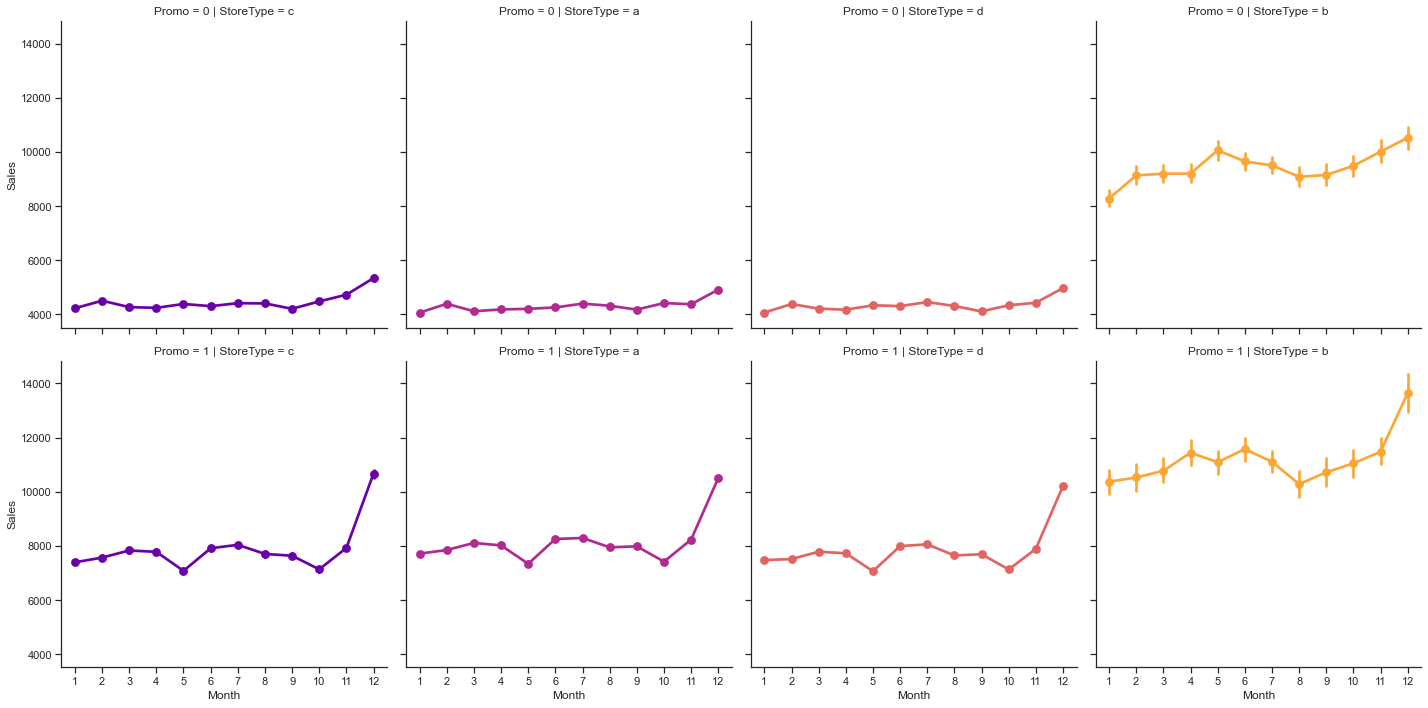

In [265]:
# sales trends
color="red"
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = color) 

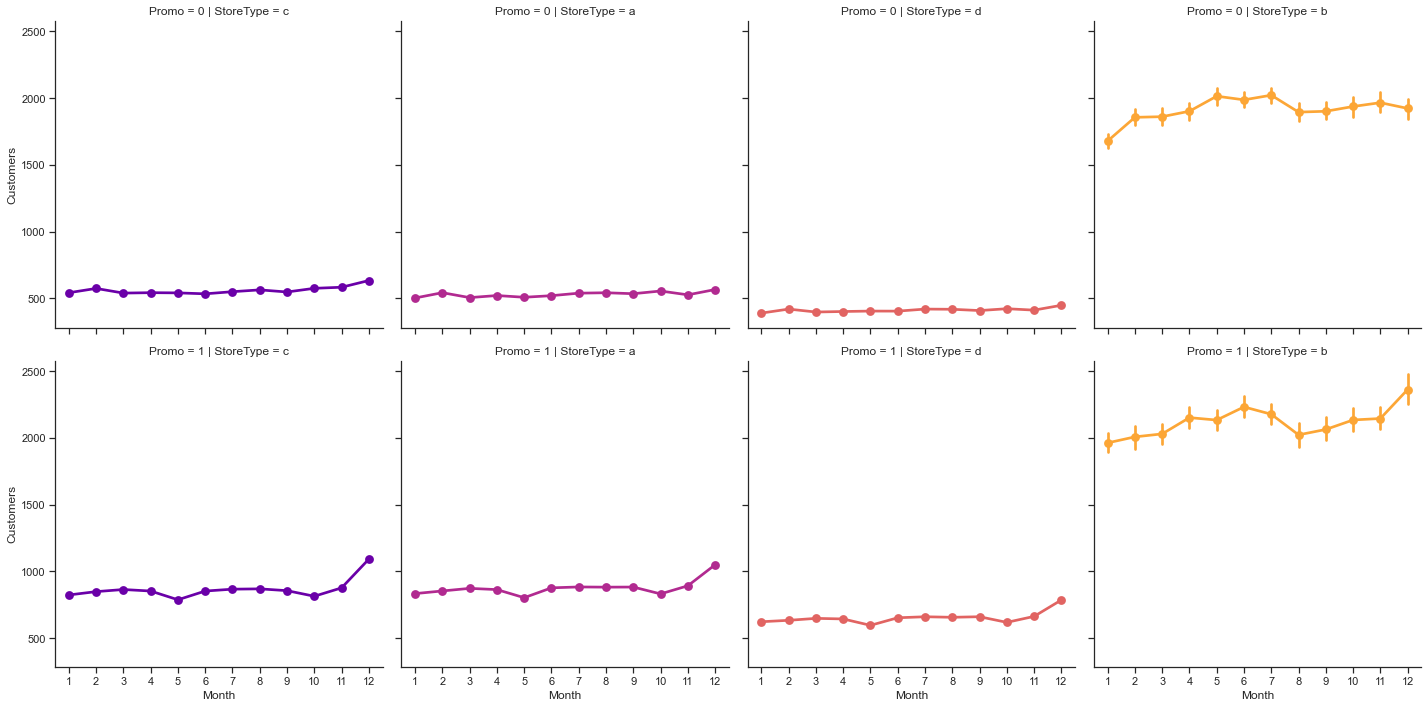

In [266]:
# Customer trends
c="blue"
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

All store types follow the same trend but at different scales depending on the presence of the (first) promotion Promo and StoreType itself (case for B).

#### Already at this point, we can see that Sales escalate towards Christmas holidays. But we'll talk about seasonalities and trends later in the Time Series Analysis section.

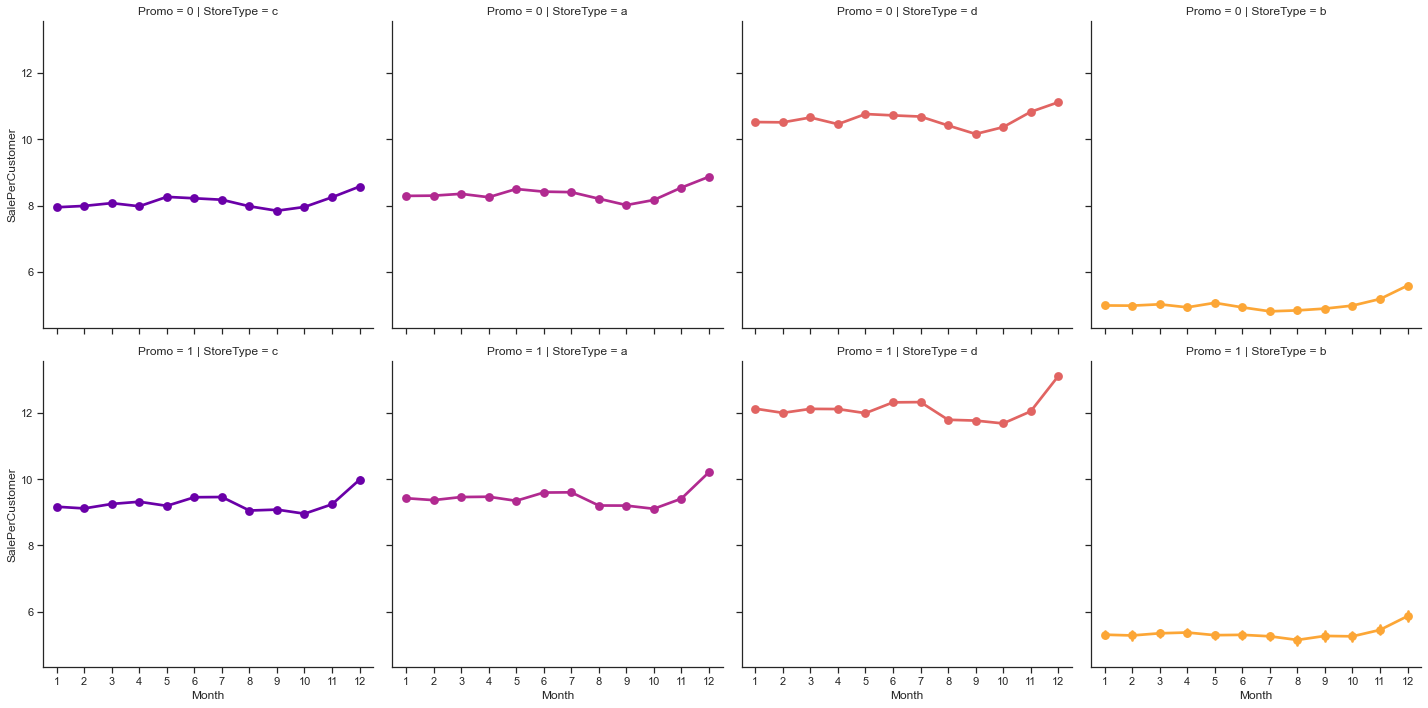

In [267]:
# sale per customer trends
c="green"
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

Aha! Eventhough the plots above showed StoreType B as the most selling and performant one, in reality it is not true. The highest SalePerCustomer amount is observed at the StoreType D, about 12€ with Promo and 10€ without. As for StoreType A and C it is about 9€.

Low SalePerCustomer amount for StoreType B describes its Buyer Cart: there are a lot of people who shop essentially for "small" things (or in a little quantity). Plus we saw that overall this StoreType generated the least amount of sales and customers over the period.

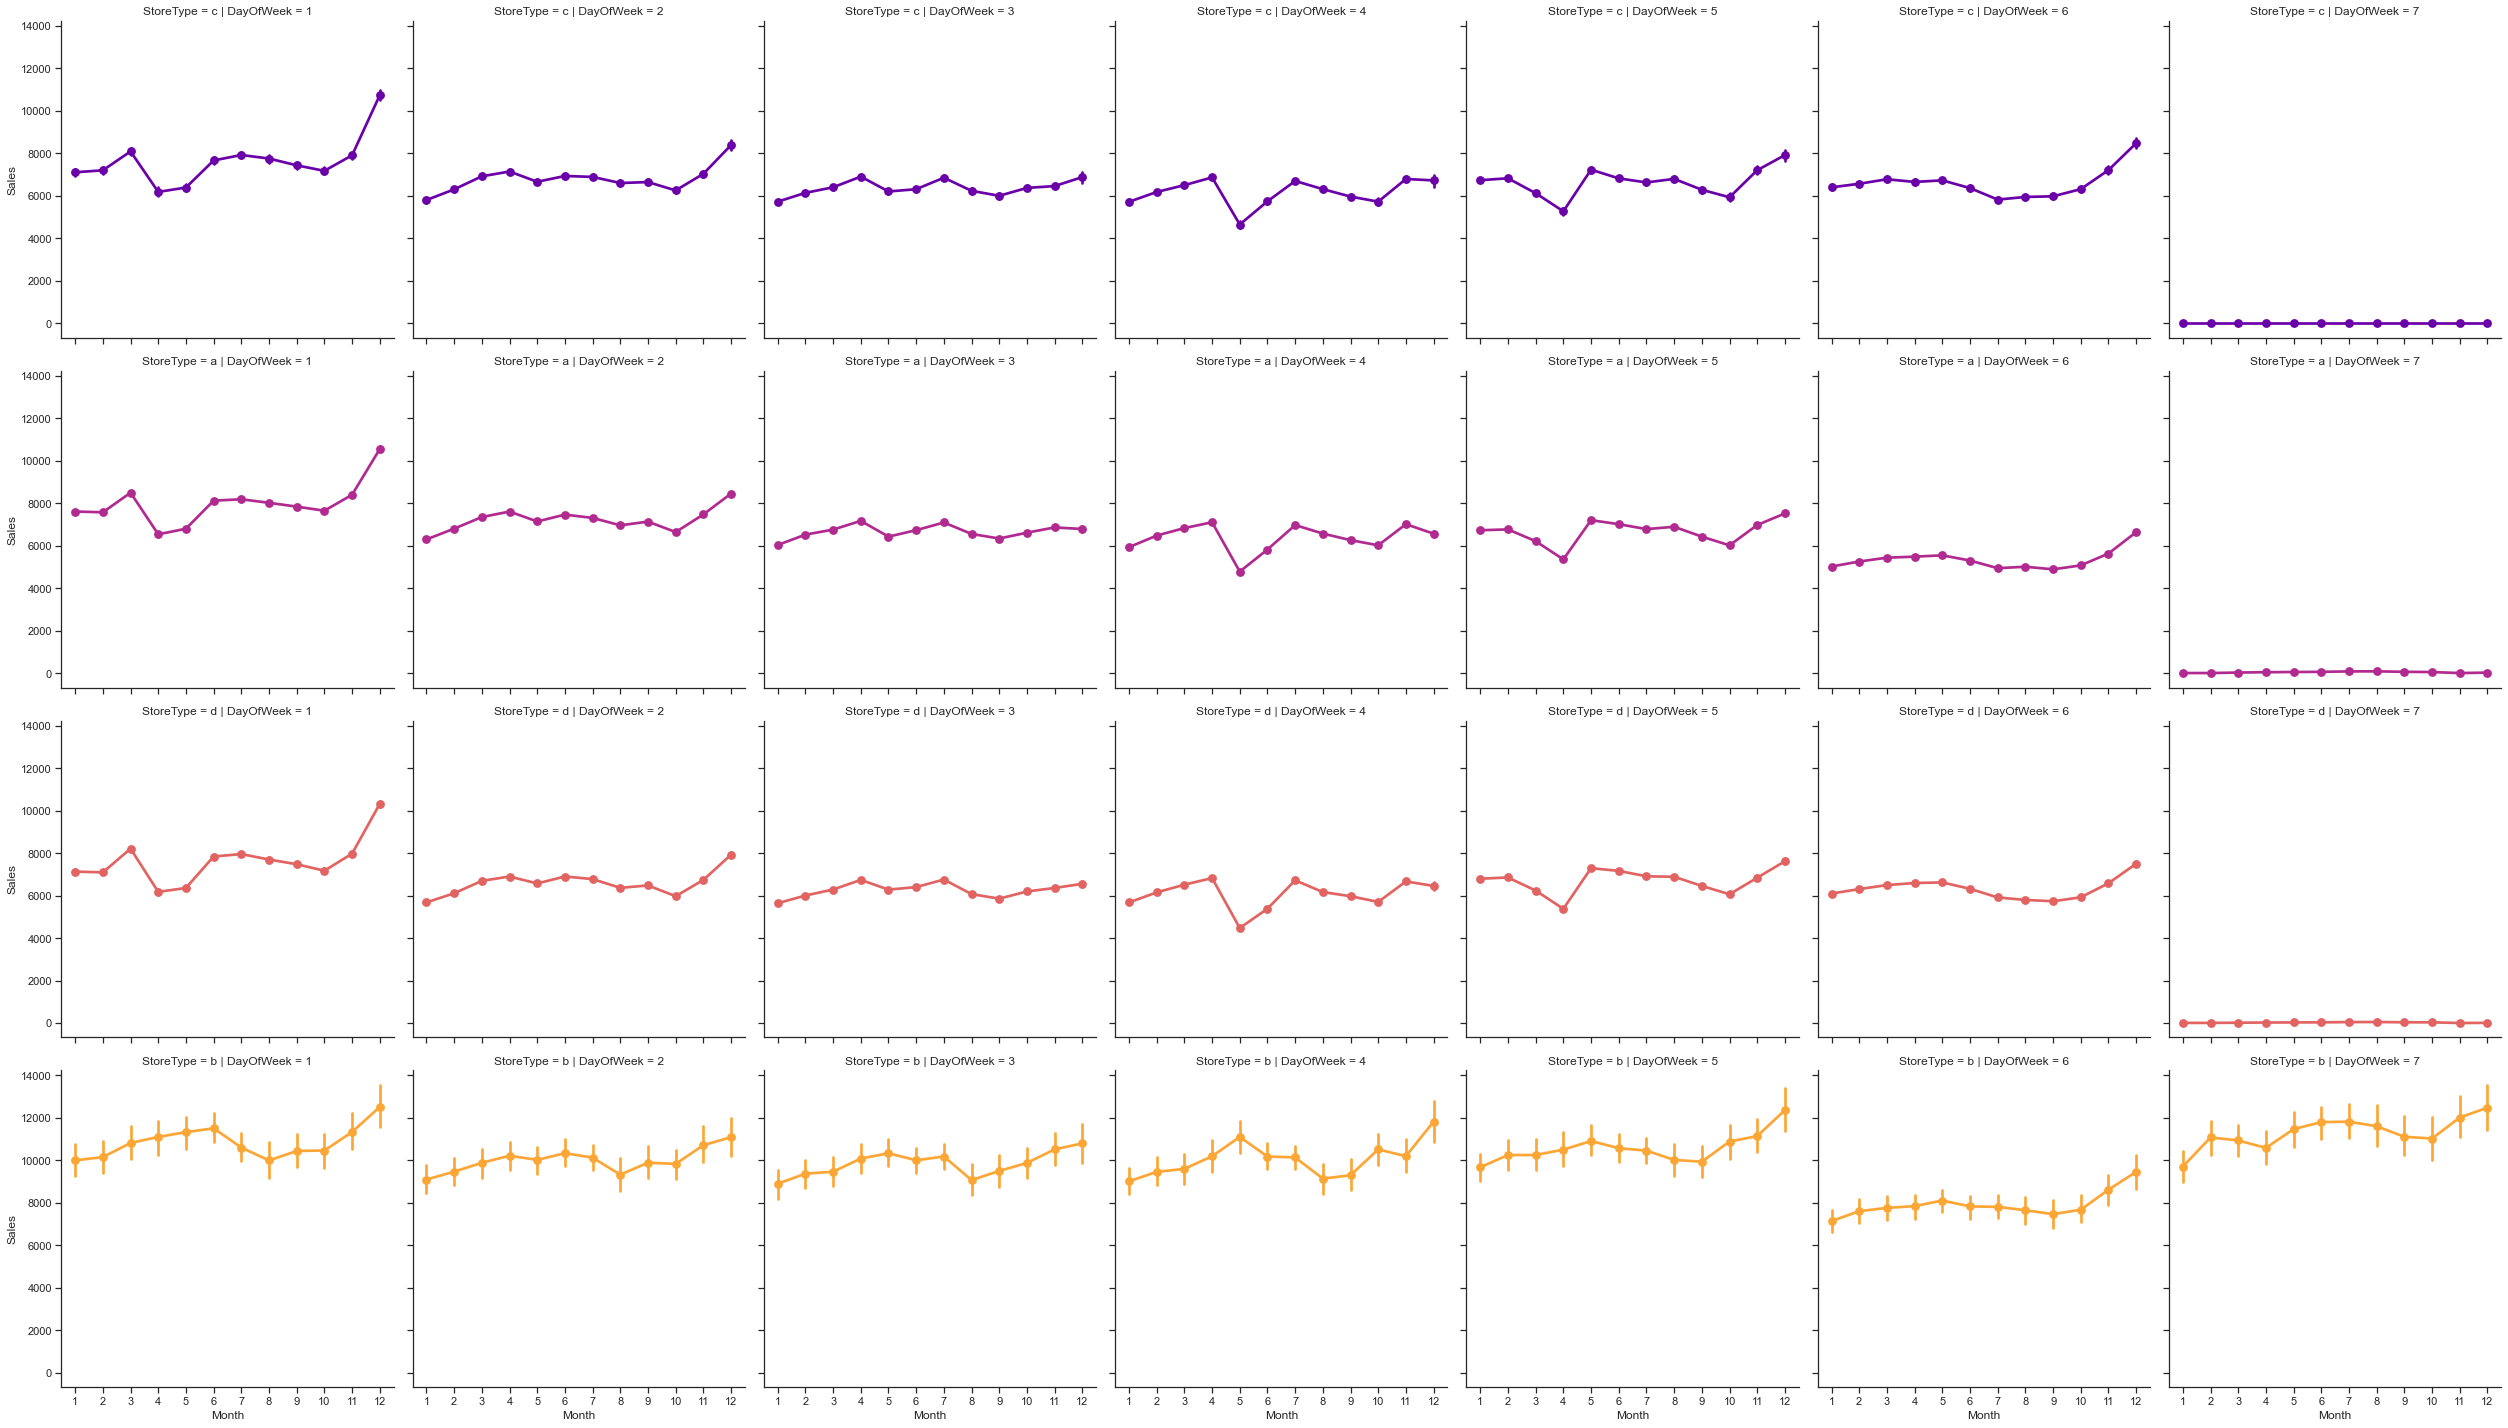

In [268]:
# customers
c="blue"
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c) 

We see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of StoreType D are closed on Sundays only from October to December.

Bt the way what are the stores which are opened on Sundays?

In [269]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

To complete our preliminary data analysis, we can add variables describing the period of time during which competition and promotion were opened:

In [270]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,5738.179710,659.034880,12882.592255,7122.919204
b,10058.837334,1987.720846,17264.621605,11264.823310
c,5723.629246,673.265894,12128.625157,6737.717159
d,5641.819243,501.434892,10397.346995,9038.541369


The most selling and crowded StoreType A doesn't appear to be the one the most exposed to competitors. Instead it's a StoreType B, which also has the longest running period of promotion.

## Correlational Analysis

We are finished with adding new variables to the data, so now we can check the overall correlations by plotting the seaborn heatmap:

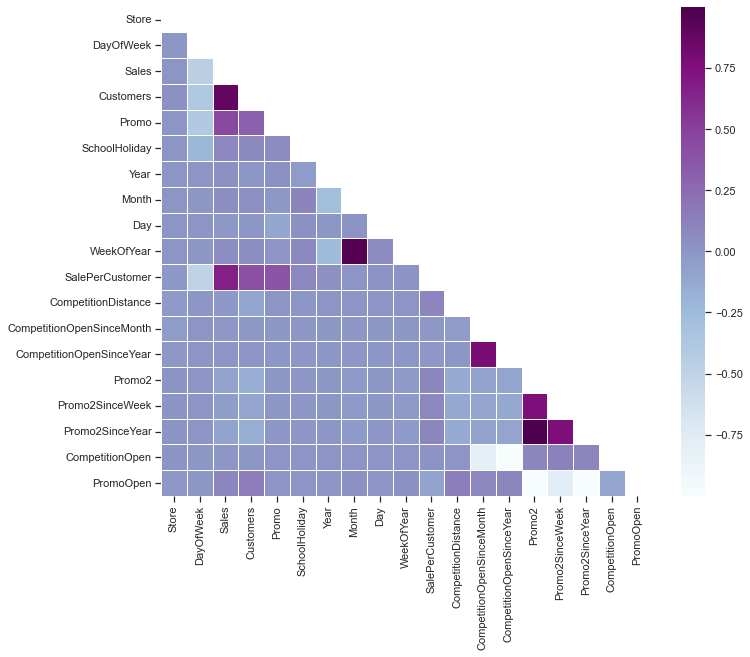

In [271]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

As mentioned before, we have a strong positive correlation between the amount of Sales and Customers of a store. We can also observe a positive correlation between the fact that the store had a running promotion (Promo equal to 1) and amount of Customers.

However, as soon as the store continues a consecutive promotion (Promo2 equal to 1) the number of Customers and Sales seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap. The same negative correlation is observed between the presence of the promotion in the store and the day of a week.

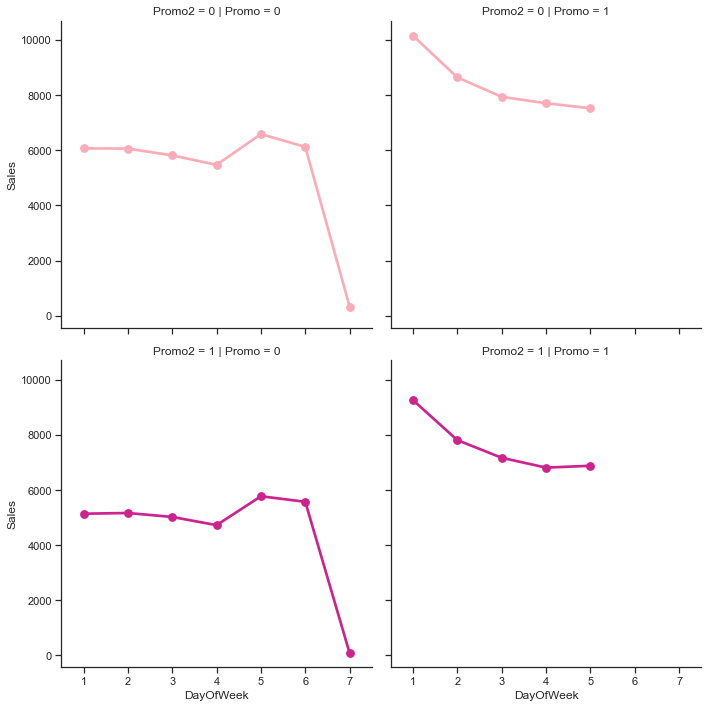

In [272]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

There are several things here:
1. In case of no promotion, both Promo and Promo2 are equal to 0, Sales tend to peak on Sunday (!). Though we should note that StoreType C doesn't work on Sundays. So it is mainly data from StoreType A, B and D.
2. On the contrary, stores that run the promotion tend to make most of the Sales on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (Promo and Promo2 are equal to 1).
3. Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount. This can be also prooved by the blue pale area on the heatmap above.

### Conclusion of EDA

1. The most selling and crowded StoreType is A.
2. The best "Sale per Customer" StoreType D indicates to the higher Buyer Cart. To benefit from this fact, Rossmann can consider proposing bigger variety of its products.
3. Low SalePerCustomer amount for StoreType B indicates to the possible fact that people shop there essentially for "small" things. Eventhough this StoreType generated the least amount of sales and customers over the whole period, it shows a great potential.
4. Customers tends to buy more on Modays when there's one promotion (Promo) and on Sundays when there's no promotion at all (both Promo and Promo1 are equal to 0).
5. Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount.

### Time-Series Analysis per Store Type

What makes a time series different from a regular regression problem?

1. It is time dependent. The basic assumption of a linear regression that the observations are independent doesn’t hold in this case.
1. Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for Christmas holidays, which we will see in this dataset.

We build a time series analysis on store types instead of individual stores. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonalities in the dataset.

In this section, we will analyse time series data: its trends, sesonalities and autocorrelation. Usually at the end of the analysis, we are able to develop a seasonal ARIMA (Autoregression Integrated Moving Average) model but it won't be our main focus today. Instead, we try to understand the data, and only later come up with the forecasts using Prophet methodology.

### Seasonality

We take four stores from store types to represent their group:

1. Store number 2 for StoreType A
2. Store number 85 for StoreType B,
3. Store number 1 for StoreType C
4. Store number 13 for StoreType D.

We take four stores from store types to represent their group:
Store number 2 for StoreType A
Store number 85 for StoreType B,
Store number 1 for StoreType C
Store number 13 for StoreType D.
It also makes sense to downsample the data from days to weeks using the resample method to see the present trends more clearly.

In [274]:
# preparation: input should be float type
train_df['Sales'] = train_df['Sales'] * 1.0

# store types
#sales_a = train_df[train_df.Store == 2]['Sales']

#sales_b = train_df[train_df.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
#sales_c = train_df[train_df.Store == 1]['Sales']
#sales_d = train_df[train_df.Store == 13]['Sales']

#f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
#sales_a.resample('W').sum().plot(color = c, ax = ax1)
#sales_b.resample('W').sum().plot(color = c, ax = ax2)
#sales_c.resample('W').sum().plot(color = c, ax = ax3)
#sales_d.resample('W').sum().plot(color = c, ax = ax4)

Retail sales for StoreType A and C tend to peak for the Christmas season and then decline after the holidays. We might have seen the same trend for StoreType D (at the bottom) but there is no information from July 2014 to January 2015 about these stores as they were closed.

### Yearly trend

The next thing to check the presence of a trend in series.

<AxesSubplot:>

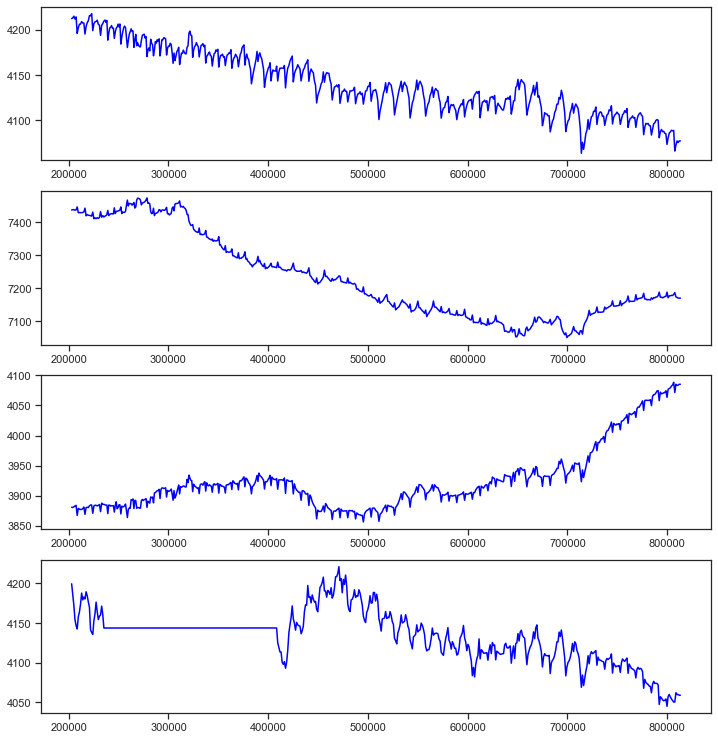

In [275]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', period = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', period = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', period = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', period = 365)
decomposition_d.trend.plot(color = c, ax = ax4)

Overall sales seems to increase, however not for the StoreType C (a third from the top). Eventhough the StoreType A is the most selling store type in the dataset, it seems that it cab follow the same decresing trajectory as StoreType C did.

## Autocorrelaion

The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

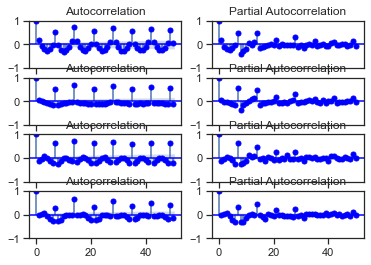

In [276]:
# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()


We can read these plots horizontally. Each horizontal pair is for one 'StoreType', from A to D. In general, those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

There is at two things common for each pair of plots: non randomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).

1. Type A and type B: Both types show seasonalities at certain lags. For type A, it is each 12th observation with positives spikes at the 12 (s) and 24(2s) lags and so on. For type B it's a weekly trend with positives spikes at the 7(s), 14(2s), 21(3s) and 28(4s) lags.
2. Type C and type D: Plots of these two types are more complex. It seems like each observation is coorrelated to its adjacent observations.

## Time Series Analysis and Forecasting with Prophet

The Core Data Science team at Facebook recently published a new procedure for forecasting time series data called Prophet. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It enables performing automated forecasting which are already implemented in R at scale in Python 3.

In [277]:
# importing data
df = pd.read_csv('../data/train.csv',  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [278]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


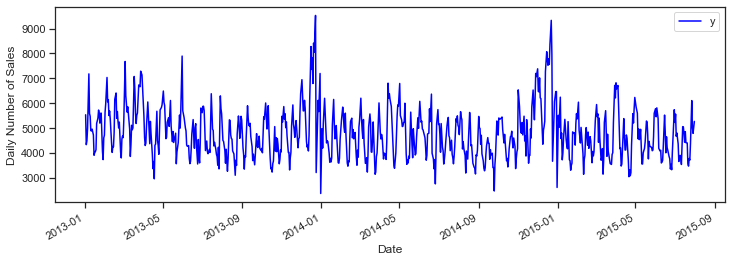

In [279]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

### Modeling Holidays

Prophet also allows to model for holidays, and that's what we do here.

The StateHoliday variable in the dataset indicates a state holiday, at which all stores are normally closed. There are also school holidays in the dataset at which ceratin stores are also closing their doors.

In [280]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [281]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [282]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4092.196373,2402.047160,5639.373551
817,2015-09-06,4086.982771,2342.722858,5717.150445
818,2015-09-07,4161.672877,2602.823166,5811.648052
819,2015-09-08,3664.111439,2029.788008,5219.049371
820,2015-09-09,3550.936324,1977.129799,5106.294012
821,2015-09-10,3462.430053,1911.844709,5112.596639
822,2015-09-11,3717.080395,2178.245595,5368.361199


The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [284]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

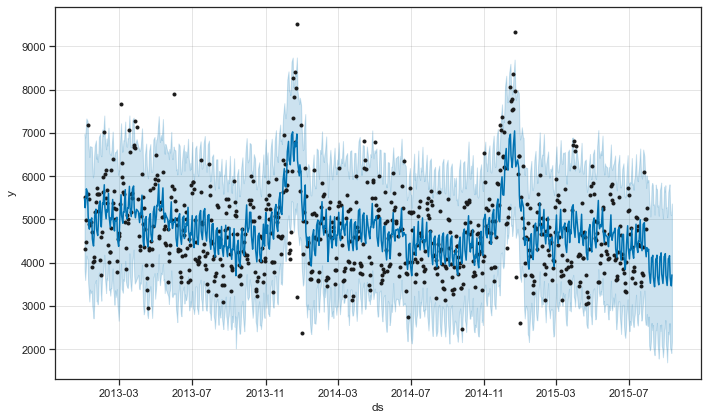

In [285]:
# visualizing predicions
my_model.plot(forecast);

As we see Prophet catches the trends and most of the time gets future values right.

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series plus manyally included holidayes contribute to the overall forecasted values:

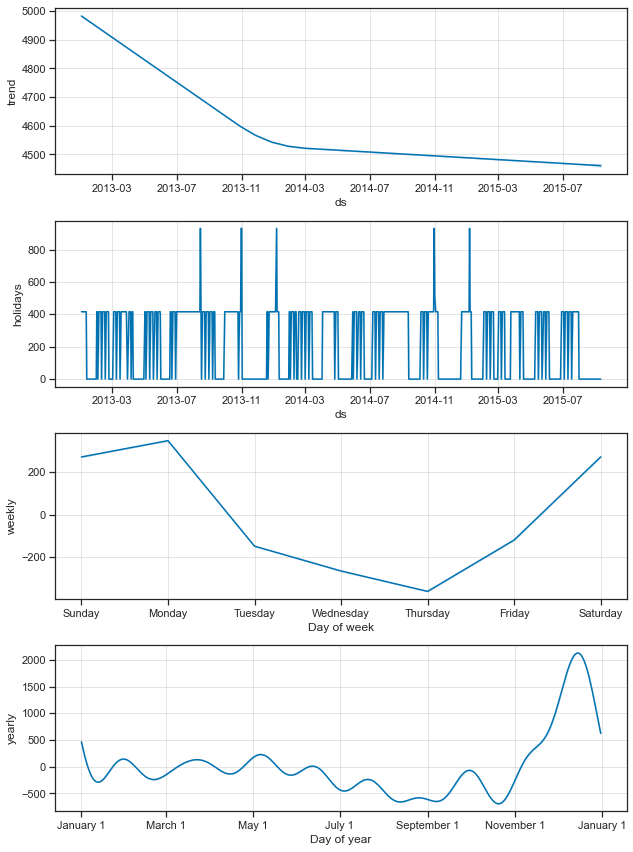

In [286]:
my_model.plot_components(forecast);

The first plot shows that the monthly sales of store number 1 has been linearly decreasing over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the most buzy season occurs during the Christmas holidays.

## Conclusion of Time Series forecasting

During this part, we discussed time series analysis with .seasonal_decompose(), ACF and PCF plots and fitted forecasting model using a new procedure by Facebook Prophet.

We can now present main advantages and drawbacks of time series forecasting:

### Advantages

1. A powerful tool for the time series forecasting as it accounts for time dependencies, seasonalities and holidays (Prophet: manually).
2. Easily implemented with R auto.arima() from forecast package, which runs a complex grid search and sophisticated algorithm behind the scene.

### Drawbacks

1. Doesn't catch interactions between external features, which could improve the forecasting power of a model. In our case, these variables are Promo and CompetitionOpen.
2. Even though Prophet offers an automated solution for ARIMA, this methodology is under development and not completely stable.
3. Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the biggest drawback for new companies.
4. Seasonal ARIMA in Python has 7 hyper parameters which can be tuned only manually affecting significantly the speed of the forecasting process.

## Getting Insightes

### Check for distribution in both training and test sets - are the promotions distributed similarly between these two groups?

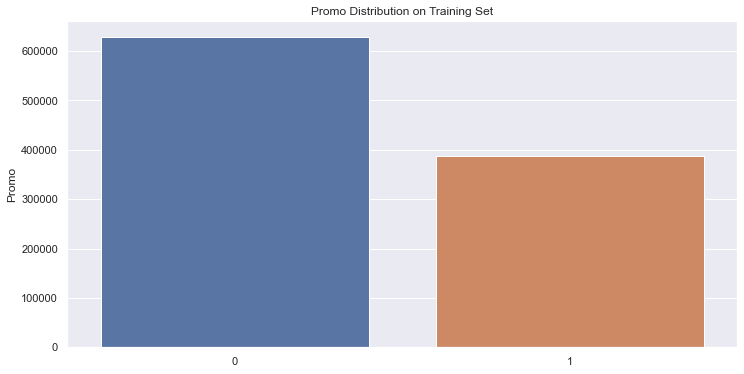

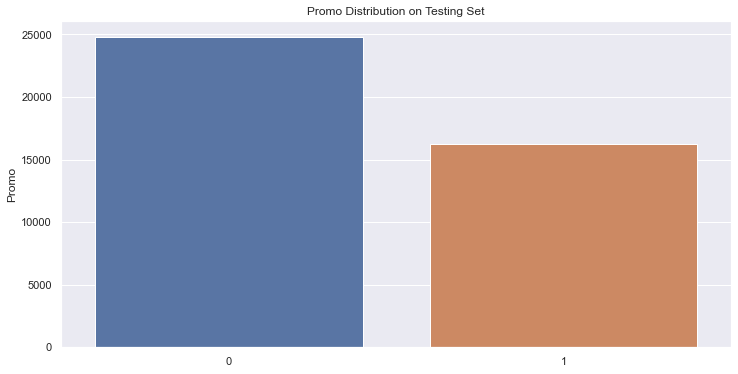

In [23]:
train_distribution = train_df.Promo.value_counts()
test_distribution = test_df.Promo.value_counts()

plot.bar(train_distribution.index, train_distribution, "Promo Distribution on Training Set")
plot.bar(test_distribution.index, test_distribution, "Promo Distribution on Testing Set")

### !!!! Check & compare sales behavior before, during and after holidays !!!

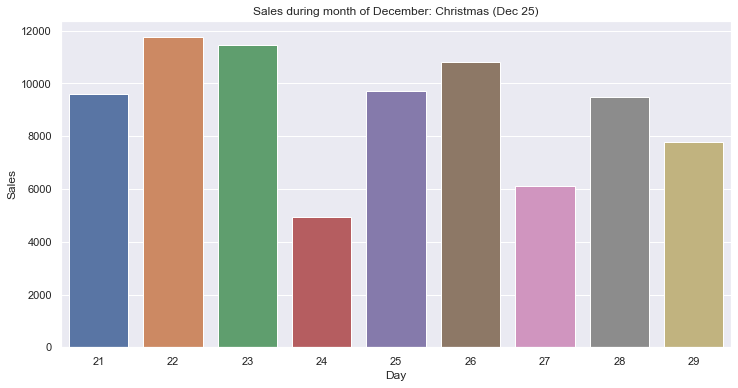

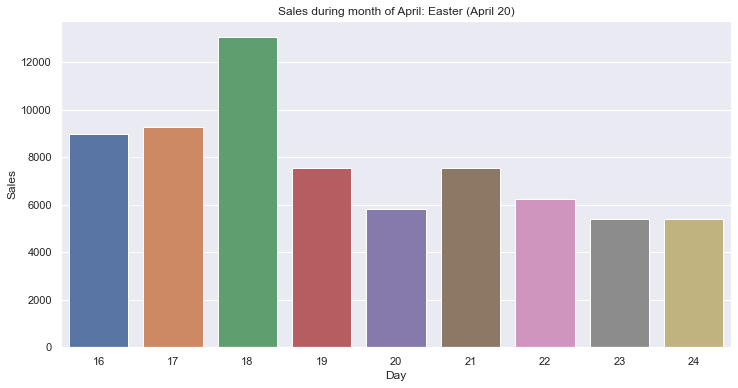

In [24]:
open_store = train_store[(train_store.Open == 1) & (train_store.Year == 2014)]

christmass_month = 12
eastern_month = 4

christmass_month = open_store[open_store.Month == christmass_month]
eastern_month = open_store[open_store.Month == eastern_month]

# plot.bar(chris['Day'], chris['Sales'], 'Sales during month of December: Christmas (Dec 25)')
# plot.bar(eastern['Day'], eastern['Sales'], 'Sales during month of April: Eastern (April 20)')

around_christmas = christmass_month[(christmass_month['Day'] > 20) & (christmass_month['Day'] < 30)]
around_christmas = around_christmas[['Day', 'Sales']].groupby('Day').mean()


around_eastern = eastern_month[(eastern_month['Day'] > 15) & (eastern_month['Day'] < 25)]
around_eastern = around_eastern[['Day', 'Sales']].groupby('Day').mean()

plot.bar(around_christmas.index, around_christmas['Sales'], 'Sales during month of December: Christmas (Dec 25)')
plot.bar(around_eastern.index, around_eastern['Sales'], 'Sales during month of April: Easter (April 20)')

Insight:-> There were more sales before and after the Holidays, rather than on the holidays

### What can you say about the correlation between sales and number of customers?

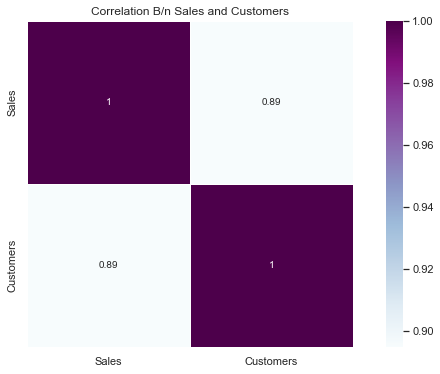

In [25]:
plot.heatmap(train_store[['Sales', 'Customers']], title='Correlation B/n Sales and Customers')

Insight :-> There is a high correlation b/n Sales and Customers. The more customers the more sales

### How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers

<Figure size 864x504 with 0 Axes>

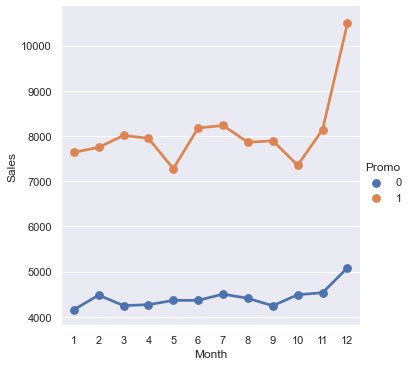

In [25]:
plt.figure(figsize=(12,7))
sns.factorplot(data = train_store, x ="Month", y = "Sales",
               hue = 'Promo',
              sharex=False)

<Figure size 864x504 with 0 Axes>

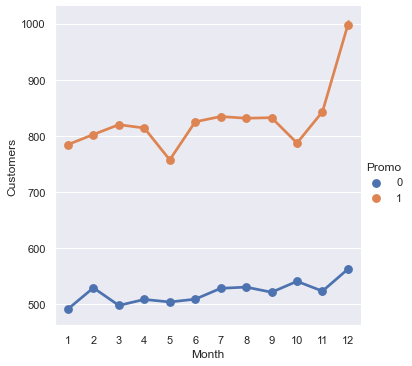

In [26]:
plt.figure(figsize=(12,7))
sns.factorplot(data = train_store, x ="Month", y = "Customers",
               hue = 'Promo',
              sharex=False)

Insight :-> Having a promotion increase the Sales and also the customers

### Could the promos be deployed in more effective ways? Which stores should promos be deployed in?

Number of Stores with less than 5143.545555555556 mean sales are 112


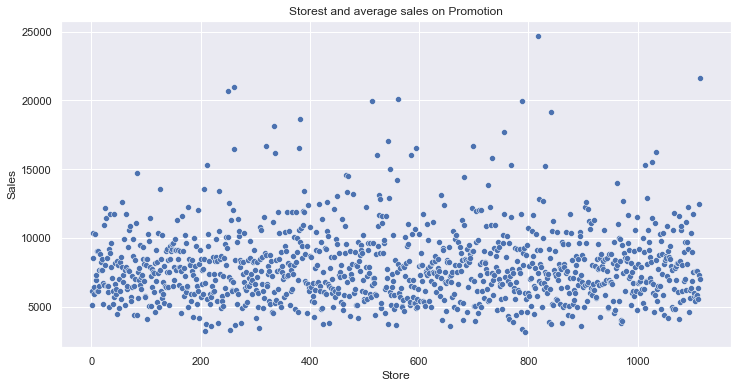

In [27]:
'''
Promo should be deployed on stores which have __ sales and __ customers (more, **less)?
'''

store_with_promo = train_store[train_store.Promo == 1]
result = store_with_promo[['Store','Sales', 'Customers']].groupby('Store').agg({"Sales":"mean", 'Customers':'sum'})

low_sales = result['Sales'].quantile(0.1) # least 10 percent sales
small_sales = result[(result['Sales'] <= low_sales)]

print(f"Number of Stores with less than {low_sales} mean sales are {small_sales.shape[0]}")
plot.scatter(result, "Store","Sales", 'Storest and average sales on Promotion')

Iinsight :-> so we have 112 stores which will need more promotion to increase the sales

### Trends of customer behavior during store open and closing times

<Figure size 864x504 with 0 Axes>

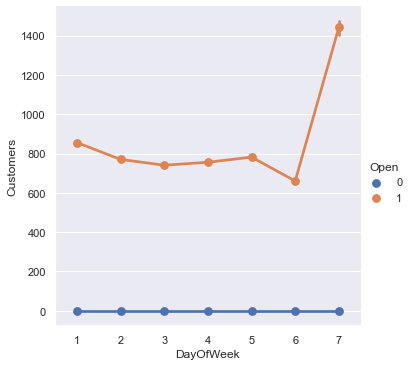

In [28]:
plt.figure(figsize=(12,7))
sns.factorplot(data = train_store, x ="DayOfWeek", y = "Customers",
               hue = 'Open',
              sharex=False)

### Which stores are opened on all weekdays? How does that affect their sales on weekends

Stores That work all Week are : 33


<Figure size 864x504 with 0 Axes>

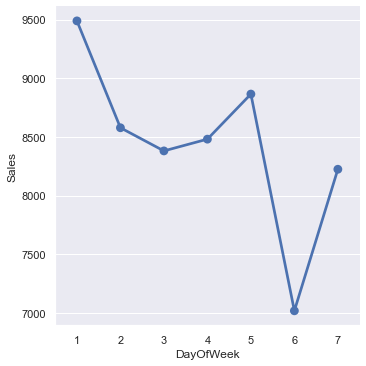

In [29]:
# stores, where their unique DayOfWeek count to 7
open_stores = train_store[train_store.Open == 1]
each_day = open_stores[['Store', 'DayOfWeek']].groupby('Store').nunique()

all_week_stores = each_day[each_day.DayOfWeek == 7]
stores_id = all_week_stores.reset_index()['Store']

get_stores = open_stores[(open_stores.Store.isin(set(stores_id)))]
get_stores = get_stores[['Store', 'Sales', 'Customers', 'DayOfWeek']]

week_sales = get_stores.groupby('DayOfWeek').mean().reset_index()

plt.figure(figsize=(12,7))
sns.factorplot(data = week_sales, x ="DayOfWeek", y = "Sales",
              sharex=False)
print(f'Stores That work all Week are : {all_week_stores.shape[0]}')

Insight :-> we have about 33 stores that work on all weedays, and the sales on week ends show rise from Saturday to sunday

### Check how the assortment type affects sales

INFO:root:util.py - get assortment for value of a
INFO:root:util.py - get assortment for value of b
INFO:root:util.py - get assortment for value of c


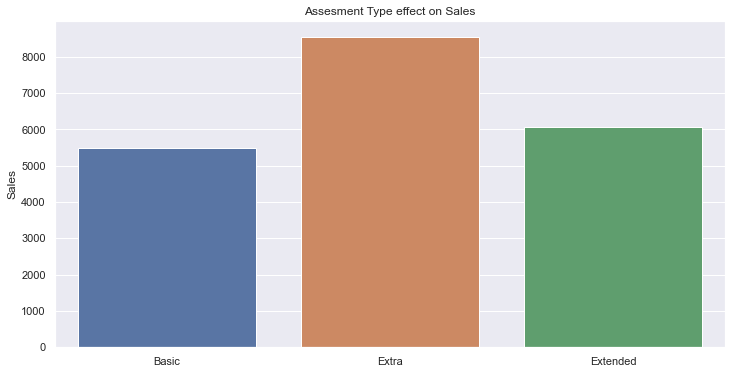

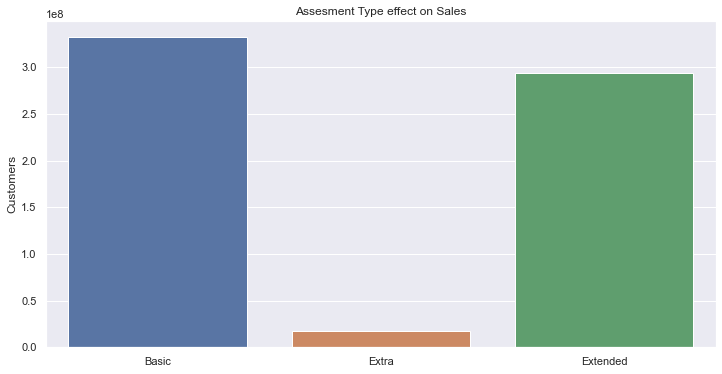

,Assortment,Sales,Customers
0,a,5481.026096,332766938
1,b,8553.931999,16972525
2,c,6058.676567,294302292


In [30]:
assortment = train_store.groupby('Assortment').agg({'Sales':'mean','Customers':'sum'}).reset_index()
assort_values = [util.get_assortment(x) for x in assortment.Assortment]

plot.bar(x=assort_values, y=assortment.Sales, title='Assesment Type effect on Sales')
plot.bar(x=assort_values, y=assortment.Customers, title='Assesment Type effect on Sales')
assortment
# sns.factorplot(data = assortment, x ="Assortment", y = "Customers",
#               sharex=False)

Insight:-> Stores with extra assortment have hights mean sales. but extra assortment got lowest customers

### How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centres, does the distance matter in that case?

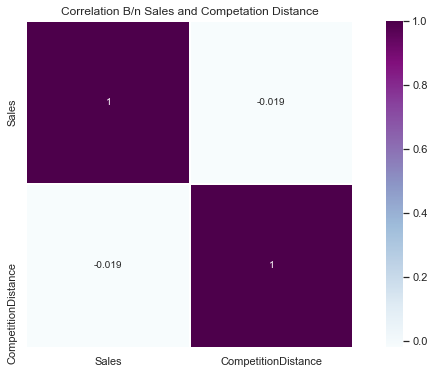

In [31]:
columns = train_store[['Sales', 'CompetitionDistance']]
plot.heatmap(columns, title='Correlation B/n Sales and Competation Distance')

Insight :-> The more the closer the stores the higher the sales, and the more the distant the lower the sales.

### How does the opening or reopening of new competitors affect stores?

In [26]:
train_store["CompetitionOpenSinceYear"].unique()

array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
          0., 2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961.,
       1995., 2001., 1990., 1994., 1900., 1998.])

<AxesSubplot:xlabel='ComeptitionBefore', ylabel='Sales'>

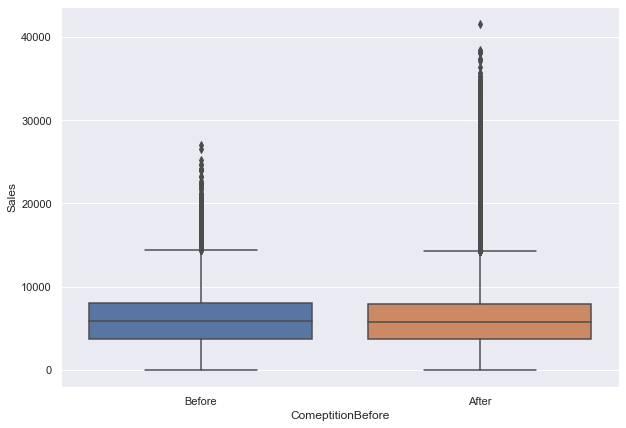

In [29]:
has_open_competition_df = train_store[train_store['CompetitionOpenSinceMonth'].notnull()]

has_open_competition_df["CompetitionOpenSinceYear"] = has_open_competition_df["CompetitionOpenSinceYear"].astype("int")
has_open_competition_df["CompetitionOpenSinceMonth"] = has_open_competition_df["CompetitionOpenSinceMonth"].astype("int")


sales_before_competition_open = has_open_competition_df[(has_open_competition_df["Year"] < has_open_competition_df["CompetitionOpenSinceYear"]) & (has_open_competition_df["Month"] < has_open_competition_df["CompetitionOpenSinceMonth"]) ]

sales_after_competition_open = has_open_competition_df[(has_open_competition_df["Year"] >= has_open_competition_df["CompetitionOpenSinceYear"]) & (has_open_competition_df["Month"] >= has_open_competition_df["CompetitionOpenSinceMonth"])]

sales_before_competition_open["ComeptitionBefore"]="Before"
sales_after_competition_open["ComeptitionBefore"]="After"

competition_sales_data=pd.concat([sales_before_competition_open,sales_after_competition_open])

plt.figure(figsize=(10, 7))
sns.boxplot(x='ComeptitionBefore', y='Sales', data=competition_sales_data)